# Data

Let's load and explore the data.

In [43]:
# # Filesystem, etc
# from google.colab import drive
# drive.mount('/content/drive')
# !ls /content/drive

# !git clone https://github.com/mertdumenci/sat-ml.git
# !cd sat-ml && git checkout md/fall-2019 && git pull origin md/fall-2019

# import sys
# sys.path.append('sat-ml')

# !pip3 install numpy torch matplotlib

# Imports
%matplotlib inline

import numpy as np
import pickle
import matplotlib.pyplot as plt

from satml import expression, fast_cnf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [44]:
# Load data.

TRAIN_SPLIT = 0.8
DATA_FILE = 'data/sr_20_batch740000_formulas606136.pickle'
# DATA_FILE = 'data/toy_batch0_formulas27.pickle'

with open(DATA_FILE, 'rb') as f:
    decisions = pickle.load(f)

assert decisions is not None

# Extract the maximum number of variables.
len_vocab = max((max((max(c) for c in formula)) for formula, _ in decisions))
len_class = len_vocab * 2

print("Loaded {} decisions".format(len(decisions)))

# Split into training/test sets.
num_training = int(len(decisions) * TRAIN_SPLIT)
decisions_training, decisions_test = decisions[:num_training], decisions[num_training:]

def encode_policy(policy) -> int:
    """Maps a policy tuple to an ordinal class."""
    idx, branch = policy
    zero_idx = idx - 1
    return zero_idx * 2 + int(branch)

Loaded 606136 decisions


## Exploration

Let's look at how the approximate optimal heuristic is distributed. We're expecting a roughly uniform distribution over variable names, as variables are initially named randomly and our renaming is a bijection, preserving its randomness.

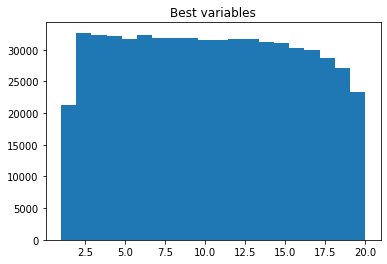

In [45]:
picked_vars, picked_assignments = zip(*((int(var), int(assignment)) for _, (var, assignment) in decisions))
picked_vars, picked_assignments = np.array(picked_vars), np.array(picked_assignments)

n, bins, _ = plt.hist(picked_vars, len_vocab)
plt.title('Best variables')
plt.show()

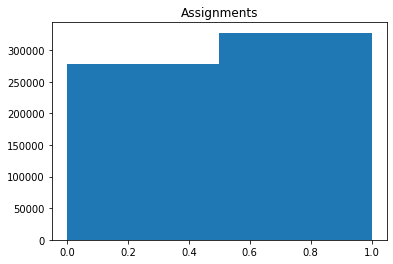

In [46]:
plt.hist(picked_assignments, 2)
plt.title('Assignments')
plt.show()

# LSTM
For the LSTM model, we need to convert our dataset of formulas in AST form into a sequence of tokens. We're going to do some preprocessing.



## Data encoding

In [5]:
len_token = len_vocab + 2 # for connectives AND and OR

def one_hot(length: int, index: int):
    element = -1 if index < 0 else 1
    index = abs(index)
    
    v = [0] * length
    v[index] = element
    return v

SPECIAL_TOKENS = {
    expression.Type.AND: one_hot(len_token, len_vocab),
    expression.Type.OR: one_hot(len_token, len_vocab + 1)
}

def tokenize_fastcnf(formula):
    tokenized = []
    for i, clause in enumerate(formula):
        # Intersperse conjunct tokens
        if i > 0:
            tokenized.append(SPECIAL_TOKENS[expression.Type.AND])
        
        for j, literal in enumerate(clause):
            # Intersperse disjunct tokens
            if j > 0:
                tokenized.append(SPECIAL_TOKENS[expression.Type.OR])
            
            zero_idx_var = literal - 1
            tokenized.append(one_hot(len_token, zero_idx_var))

    return torch.FloatTensor(tokenized)

def tokenize_formula(formula):
    return torch.FloatTensor(_tokenize_formula(formula))

def _tokenize_formula(formula):
    if not formula:
        return []
    
    assert isinstance(formula, expression.Expression)
    
    typ, l_val, r_val = formula

    # We're at a variable, embed it.
    if typ == expression.Type.VAR:
        # Variables are 1-indexed
        zero_idx = int(l_val) - 1
        return [one_hot(len_token, zero_idx)]
    # We're at a NOT'd variable, reach one level below and embed it.
    if typ == expression.Type.NOT:
        assert l_val.typ == expression.Type.VAR, "Expecting negations to be propagated to literal level"
        zero_idx = int(l_val.l_val) - 1
        return [one_hot(len_token, -1 * zero_idx)]

    # Else join tokenizations of branches into one sequence
    return _tokenize_formula(l_val) + [SPECIAL_TOKENS[typ]] + _tokenize_formula(r_val)

## Model

Now let's define the LSTM model.

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, linear_1_dim: int, linear_2_dim: int, num_lstm_layers: int):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, num_lstm_layers, batch_first=True)

        self.linear_1 = nn.Linear(self.hidden_dim, linear_1_dim)
        self.linear_2 = nn.Linear(linear_1_dim, linear_2_dim)
        
    def forward(self, packed_input):
        """Expects a packed sequence."""
        _, (hidden, _) = self.lstm(packed_input)
        
        x = hidden[-1]
        x = self.linear_1(x)
        x = self.linear_2(x)

        return x

# Graph Encoding

For the graph encoding model, we need to convert our dataset of formulas in AST into adjacency matrices.

$$M(i, j) = \mathbb{1}\{l_i \in c_j\}$$

## Data encoding

In [47]:
from functools import reduce

def adjacency(formulas):
    """
    Takes any number of formulas and returns an adjacency matrix representing the formulas
    (disconnected if > 1) formulas.
    """
    if not isinstance(formulas, list):
        formulas = [formulas]

    # Find how many variables we'll have, so that we can index beyond
    # that set for negative literals. This is a running sum.
    # 1, 4, 4, 6, 20, 30
    num_variables = reduce(lambda l, f: l + [(0 if not l else l[-1]) + len(fast_cnf.free(f))], formulas, [])
    num_clauses = 0

    # The sparse tensor we're building up
    indices = []

    for n, formula in enumerate(formulas):
        # How many variables have we seen before?
        prev_vars = 0 if n == 0 else num_variables[n - 1]

        for clause in formula:
            for j, literal in enumerate(clause):
                clause_index = num_clauses
                # Literals are 1 indexed
                literal_index = prev_vars + abs(literal) - 1
                # Negative literals go after all positive literals
                if literal < 0:
                    literal_index += num_variables[-1]
                
                indices.append([literal_index, clause_index])

            num_clauses += 1

    indices = torch.LongTensor(indices)
    values = torch.zeros(len(indices)) + 1
    # 2m + n where m is the number of literals, and n is the number of clauses
    size = torch.Size([2 * num_variables[-1], num_clauses])
    adj_matrix = torch.sparse.FloatTensor(indices.t(), values, size)

    return adj_matrix, [len(fast_cnf.free(f)) for f in formulas]

## Model

In [48]:
class Net(nn.Module):
    """Multi-layer neural net."""
    def __init__(self, input_size, output_sizes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size if i == 0 else output_sizes[i - 1], output_size)
            for i, output_size in enumerate(output_sizes)
        ])

    def forward(self, inp):
        x = inp
        for lin in self.layers:
            x = lin(x)

        return x

class GraphEmbeddingLSTM(nn.Module):
    def __init__(self, dimension, iterations):
        super(GraphEmbeddingLSTM, self).__init__()

        self.dimension = dimension
        self.iterations = iterations

        # https://github.com/ryanzhangfan/NeuroSAT/blob/master/src/neurosat.py
        # We learn the initialization vectors, hence their being linear transformations
        # (to make Pytorch happy to learn these vectors)
        self.l_init = nn.Linear(1, dimension)
        self.c_init = nn.Linear(1, dimension)

        # The message nets
        self.l_msg = Net(dimension, [dimension, dimension, dimension])
        self.c_msg = Net(dimension, [dimension, dimension, dimension])

        # The update LSTM
        self.l_u = nn.LSTM(dimension, dimension)
        self.c_u = nn.LSTM(dimension, dimension)

        # The classifier
        self.l_cls = Net(dimension, [dimension, dimension, 1])

    def forward(self, adj_matrix, num_vars):
        # Get our L_init and C_init vectors.
        x = torch.ones(1)
        x.requires_grad = False
        L_init = self.l_init(x)
        C_init = self.c_init(x)

        # Embedding matrices start out by tiling L_init, C_init.
        n_lits, n_clauses = adj_matrix.shape
        L_t = L_init.repeat(n_lits, 1)
        C_t = C_init.repeat(n_clauses, 1)

        # Hidden states for the update LSTMs
        L_h = torch.zeros((1, n_lits, self.dimension))
        L_0 = torch.zeros((1, n_lits, self.dimension))
        C_h = torch.zeros((1, n_clauses, self.dimension))
        C_0 = torch.zeros((1, n_clauses, self.dimension))
        
        for i in range(self.iterations):
            l_agg = adj_matrix.t() @ self.l_msg(L_t)
            c_agg = adj_matrix @ self.c_msg(C_t)
            
            # Clause update uses literal embedding aggregations
            _, (C_h, _) = self.c_u(l_agg.unsqueeze(0), (C_h, C_0))
            # Literal update uses clause embedding aggregations
            _, (L_h, _) = self.l_u(c_agg.unsqueeze(0), (L_h, L_0))

            # Unpack the hidden states to go back in the loop
            C_t = C_h.squeeze(0)
            L_t = L_h.squeeze(0)

        # Classify the literal embeddings
        L_imp = self.l_cls(L_t)
        L_imp = L_imp.squeeze(1)
        
        # Unpack the batch adjacency matrix
        L_imp_unpacked = []
        
        total_vars = len(L_imp) // 2
        currently_seen_vars = 0
        for n in enumerate(num_vars):
            p_lits = L_imp[currently_seen_vars:currently_seen_vars + n]
            n_lits = L_imp[total_vars + currently_seen_vars:total_vars + currently_seen_vars + n]
            
            L_imp_unpacked.append(p_lits + n_lits)
            currently_seen_vars += n
            
        return torch.FloatTensor(L_imp_unpacked)

In [49]:
class Net(nn.Module):
    """Multi-layer neural net."""
    def __init__(self, input_size, output_sizes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size if i == 0 else output_sizes[i - 1], output_size)
            for i, output_size in enumerate(output_sizes)
        ])

    def forward(self, inp):
        x = inp
        for lin in self.layers:
            x = lin(x)

        return x

class GraphEmbeddingLSTM(nn.Module):
    def __init__(self, dimension, iterations):
        super(GraphEmbeddingLSTM, self).__init__()

        self.dimension = dimension
        self.iterations = iterations

        # https://github.com/ryanzhangfan/NeuroSAT/blob/master/src/neurosat.py
        # We learn the initialization vectors, hence their being linear transformations
        # (to make Pytorch happy to learn these vectors)
        self.l_init = nn.Linear(1, dimension)
        self.c_init = nn.Linear(1, dimension)

        # The message nets
        self.l_msg = Net(dimension, [dimension, dimension, dimension])
        self.c_msg = Net(dimension, [dimension, dimension, dimension])

        # The update LSTM
        self.l_u = nn.LSTM(dimension, dimension)
        self.c_u = nn.LSTM(dimension, dimension)

        # The classifier
        self.l_cls = Net(dimension, [dimension, dimension, 1])

    def forward(self, adj_matrix, num_vars):
        # Get our L_init and C_init vectors.
        x = torch.ones(1)
        x.requires_grad = False
        L_init = self.l_init(x)
        C_init = self.c_init(x)

        # Embedding matrices start out by tiling L_init, C_init.
        n_lits, n_clauses = adj_matrix.shape
        L_t = L_init.repeat(n_lits, 1)
        C_t = C_init.repeat(n_clauses, 1)

        # Hidden states for the update LSTMs
        L_h = torch.zeros((1, n_lits, self.dimension))
        L_0 = torch.zeros((1, n_lits, self.dimension))
        C_h = torch.zeros((1, n_clauses, self.dimension))
        C_0 = torch.zeros((1, n_clauses, self.dimension))
        
        for i in range(self.iterations):
            l_agg = adj_matrix.t() @ self.l_msg(L_t)
            c_agg = adj_matrix @ self.c_msg(C_t)
            
            # Clause update uses literal embedding aggregations
            _, (C_h, _) = self.c_u(l_agg.unsqueeze(0), (C_h, C_0))
            # Literal update uses clause embedding aggregations
            _, (L_h, _) = self.l_u(c_agg.unsqueeze(0), (L_h, L_0))

            # Unpack the hidden states to go back in the loop
            C_t = C_h.squeeze(0)
            L_t = L_h.squeeze(0)

        # Classify the literal embeddings
        L_imp = self.l_cls(L_t)
        L_imp = L_imp.squeeze(1)
        
        # Unpack the batch adjacency matrix
        L_imp_unpacked = []
        
        total_vars = len(L_imp) // 2
        currently_seen_vars = 0
        for n in num_vars:
            p_lits = L_imp[currently_seen_vars:currently_seen_vars + n]
            n_lits = L_imp[total_vars + currently_seen_vars:total_vars + currently_seen_vars + n]
            lits = torch.cat((p_lits, n_lits))
            
            L_imp_unpacked.append(lits)
            currently_seen_vars += n
            
        return torch.stack(L_imp_unpacked)

# adj, n_v = adjacency([formula for formula, _ in decisions])

# emb = GraphEmbeddingLSTM(40, 3)
# emb(adj, n_v).shape

# Training loops

## Datasets


In [9]:
class LSTMDataset(data.Dataset):
    def __init__(self, fastcnf_decisions):
        self.fastcnf_decisions = fastcnf_decisions
        
    def __len__(self):
        return len(self.fastcnf_decisions)
    
    def __getitem__(self, index):
        formula, policy = self.fastcnf_decisions[index]
        return tokenize_fastcnf(formula), encode_policy(policy)
    
def lstm_collator(batch):
    """Expects `batch` to be a list of (X, y) pairs."""
    X, y = zip(*batch)
    seq_lens = torch.tensor([len(seq) for seq in X])

    padded_sequences = nn.utils.rnn.pad_sequence(X, batch_first=True)
    packed_batch = nn.utils.rnn.pack_padded_sequence(
        padded_sequences,
        seq_lens,
        batch_first=True,
        enforce_sorted=False
    )
    
    return packed_batch, torch.LongTensor(y)

lstm_dataset_train = LSTMDataset(decisions_training)
lstm_dataset_val = LSTMDataset(decisions_test)

In [50]:
class AdjacencyDataset(data.Dataset):
    def __init__(self, fastcnf_decisions):
        self.fastcnf_decisions = fastcnf_decisions
        
    def __len__(self):
        return len(self.fastcnf_decisions)
    
    def __getitem__(self, index):
        formula, policy = self.fastcnf_decisions[index]
        return formula, encode_policy(policy)
    
def adj_collator(batch):
    """Expects `batch` to be a list of (X, y) pairs."""
    X, y = zip(*batch)
    X = list(X)
    
    adj, num_vars = adjacency(X)
    
    return adj.to_dense(), torch.LongTensor(y), num_vars

adj_dataset_train = AdjacencyDataset(decisions_training)
adj_dataset_val = AdjacencyDataset(decisions_test)

## Training

In [53]:
def evaluate_validation(model, loader_validation):
    """Evaluate a model on the validation set."""
    with torch.no_grad():
        accuracy = 0

        for batch in loader_validation:
            X, y = batch[0], batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()

            y_pred = model(X, *batch[2:])

            class_predictions = y_pred.max(1)[1]
            num_accurate = class_predictions.eq(y).sum()

            accuracy += float(num_accurate) / (y.shape[0] * len(loader_validation))

    return accuracy

def train_model(
    model,
    dataset_training,
    dataset_validation,
    collate_fn,
    batch_size=64,
    epochs=150
    ):
    """Training loop."""

    # Set up the loaders
    loader_opts = {
        'collate_fn': collate_fn,
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    loader_train = data.DataLoader(dataset=dataset_training, **loader_opts)
    loader_validation = data.DataLoader(dataset=dataset_validation, **loader_opts)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters()) # Use the default LR schedule
    print_every = 1

    for t in range(epochs):
        # These are over the dataset, so we pull them in each epoch
        running_loss, running_accuracy, steps_accrued = 0, 0, 0

        for step, batch in enumerate(loader_train):
            X, y = batch[0], batch[1]
            
            model.zero_grad()
            y_pred = model(X, *batch[2:])
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                steps_accrued += 1
                class_predictions = y_pred.max(1)[1]            
                num_accurate = class_predictions.eq(y).sum()
                
                running_loss += loss.item()
                running_accuracy += float(num_accurate) / y.shape[0]
            
                if step % print_every == 0:
                    print(f"Epoch {t + 1}/{epochs} "
                        f"Step {step + 1}/{len(loader_train)} "
                        f"Train loss: {running_loss / steps_accrued} "
                        f"Train acc: {running_accuracy / steps_accrued}")
                    
        val_acc = evaluate_validation(model, loader_validation)
        print(f"Validation accuracy: {val_acc}")

### LSTM

In [0]:
lstm_model = LSTM(
    input_dim=token_length,
    hidden_dim=40,
    linear_1_dim=60,
    linear_2_dim=label_length,
    num_lstm_layers=2
)

train_model(lstm_model, lstm_dataset_train, lstm_dataset_val, lstm_collator)

### Graph Encoding

In [ ]:
adj_model = GraphEmbeddingLSTM(140, 25)
train_model(adj_model, adj_dataset_train, adj_dataset_val, adj_collator)

Epoch 1/150 Step 1/7577 Train loss: 3.6887664794921875 Train acc: 0.0
Epoch 1/150 Step 2/7577 Train loss: 3.689348578453064 Train acc: 0.0078125
Epoch 1/150 Step 3/7577 Train loss: 3.689394553502401 Train acc: 0.010416666666666666
Epoch 1/150 Step 4/7577 Train loss: 3.6900296211242676 Train acc: 0.0078125
Epoch 1/150 Step 5/7577 Train loss: 3.6900628089904783 Train acc: 0.00625
Epoch 1/150 Step 6/7577 Train loss: 3.689720312754313 Train acc: 0.010416666666666666
Epoch 1/150 Step 7/7577 Train loss: 3.689623083387102 Train acc: 0.013392857142857142
Epoch 1/150 Step 8/7577 Train loss: 3.689736396074295 Train acc: 0.015625
Epoch 1/150 Step 9/7577 Train loss: 3.689564678404066 Train acc: 0.017361111111111112
Epoch 1/150 Step 10/7577 Train loss: 3.689438796043396 Train acc: 0.01875
Epoch 1/150 Step 11/7577 Train loss: 3.689337123524059 Train acc: 0.018465909090909092
Epoch 1/150 Step 12/7577 Train loss: 3.689213752746582 Train acc: 0.01953125
Epoch 1/150 Step 13/7577 Train loss: 3.6893190603